# Calibrating GPs using MCMC

In [1]:
import os
# Ignore my broken HDF5 install...
os.putenv("HDF5_DISABLE_VERSION_CHECK", '1')

In [2]:
import pandas as pd
import numpy as np
import iris

from utils import get_aeronet_data, get_bc_ppe_data
from esem import gp_model
from esem.sampler import MCMCSampler

import os

import matplotlib.pyplot as plt
%matplotlib inline

# GPU = "1"

# os.environ["CUDA_VISIBLE_DEVICES"] = GPU

## Read in the parameters and observables

In [3]:
ppe_params, ppe_aaod = get_bc_ppe_data()

In [4]:
# Calculate the global, annual mean AAOD (CIS will automatically apply the weights)
mean_aaod, = ppe_aaod.collapsed(['latitude', 'longitude', 'time'], 'mean')

C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\iris\analysis\cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


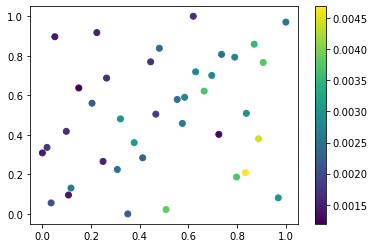

In [5]:
plt.scatter(ppe_params.BCnumber, ppe_params.Wetdep, c=mean_aaod.data)
plt.colorbar()

c:\users\duncan\pycharmprojects\gcem\esem\utils.py:119: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(X, Y, vals[:, np.newaxis], vmin=0, vmax=1)


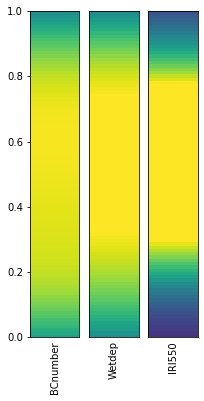

In [6]:
from esem.utils import plot_parameter_space

plot_parameter_space(ppe_params, fig_size=(3,6))

In [7]:
n_test = 8

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
Y_test, Y_train = mean_aaod[:n_test], mean_aaod[n_test:]

## Setup and run the models

In [8]:
model = gp_model(X_train, Y_train)

In [9]:
model.train()

In [10]:
m, v = model.predict(X_test.values)

In [11]:
Y_test.data

masked_array(data=[0.002822510314728863, 0.002615034735649063,
                   0.002186747212596059, 0.0015112621889264352,
                   0.004456776854431466, 0.0025203727123839117,
                   0.0022378865435589133, 0.003730134076583199],
             mask=[False, False, False, False, False, False, False, False],
       fill_value=1e+20)

Proportion of 'Bad' estimates : 0.00%


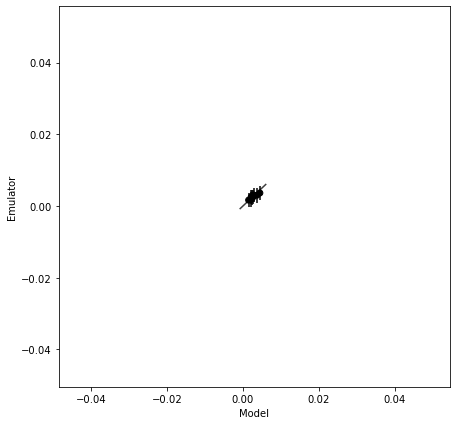

In [12]:
from esem.utils import validation_plot

validation_plot(Y_test.data.flatten(), m.data.flatten(), v.data.flatten())

In [13]:
# Set the objective as one of the test datasets
sampler = MCMCSampler(model, Y_test[0])

In [14]:
samples = sampler.sample(n_samples=800, mcmc_kwargs=dict(num_burnin_steps=100) )

Acceptance rate: 0.9262387969566703


In [15]:
new_samples = pd.DataFrame(data=samples, columns=ppe_params.columns)
m, _ = model.predict(new_samples.values)
Zs = m.data

In [16]:
print("Sample mean: {}".format(Zs.mean()))
print("Sample std dev: {}".format(Zs.std()))

Sample mean: 0.003150297212253644
Sample std dev: 0.0006305448129278108


c:\users\duncan\pycharmprojects\gcem\esem\utils.py:119: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(X, Y, vals[:, np.newaxis], vmin=0, vmax=1)


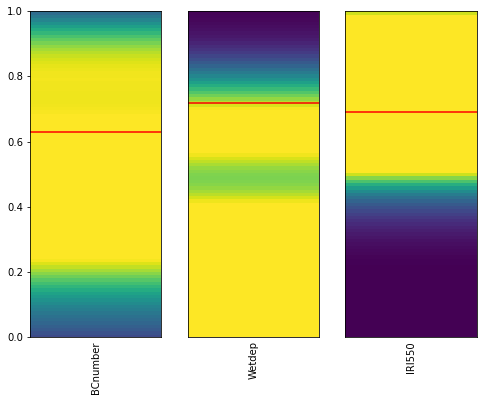

In [17]:
plot_parameter_space(new_samples, target_df=X_test.iloc[0])

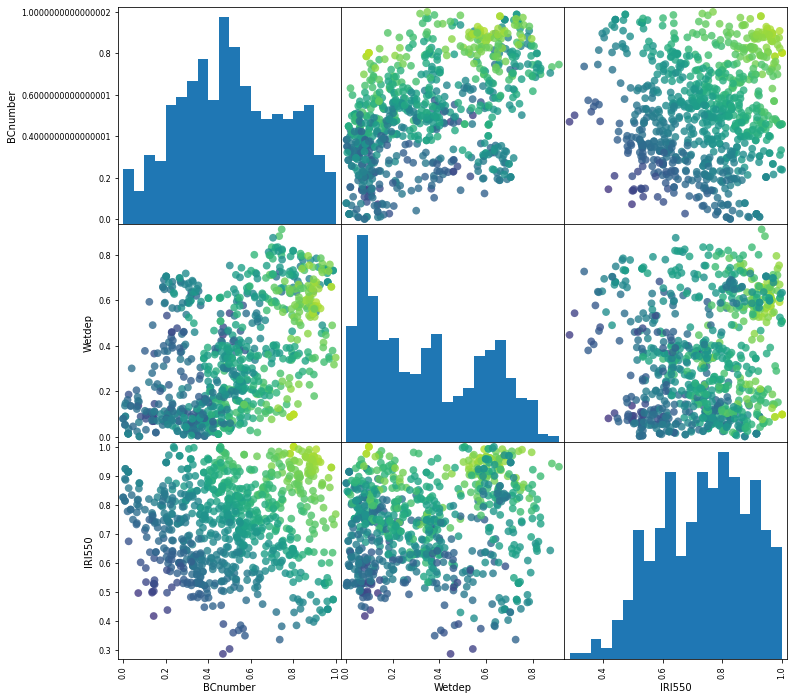

In [18]:
grr = pd.plotting.scatter_matrix(new_samples, c=Zs, figsize=(12, 12), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8, vmin=1e-3, vmax=5e-3)

In [19]:
from esem.abc_sampler import ABCSampler, constrain
from esem.utils import get_random_params

In [20]:
sampler = ABCSampler(model, Y_test[0])

samples = sampler.sample(n_samples=2000, threshold=0.5)
valid_points = pd.DataFrame(data=samples, columns=ppe_params.columns)

Acceptance rate: 0.33641715727502103


In [21]:
m, _ = model.predict(valid_points.values)
Zs = m.data

In [22]:
print("Sample mean: {}".format(Zs.mean()))
print("Sample std dev: {}".format(Zs.std()))

Sample mean: 0.002788395703569595
Sample std dev: 0.0003013221458724632


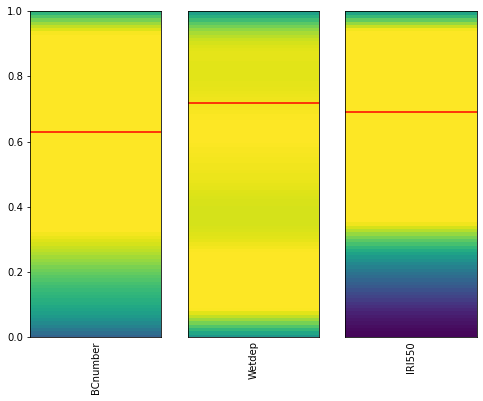

In [23]:
plot_parameter_space(valid_points, target_df=X_test.iloc[0])

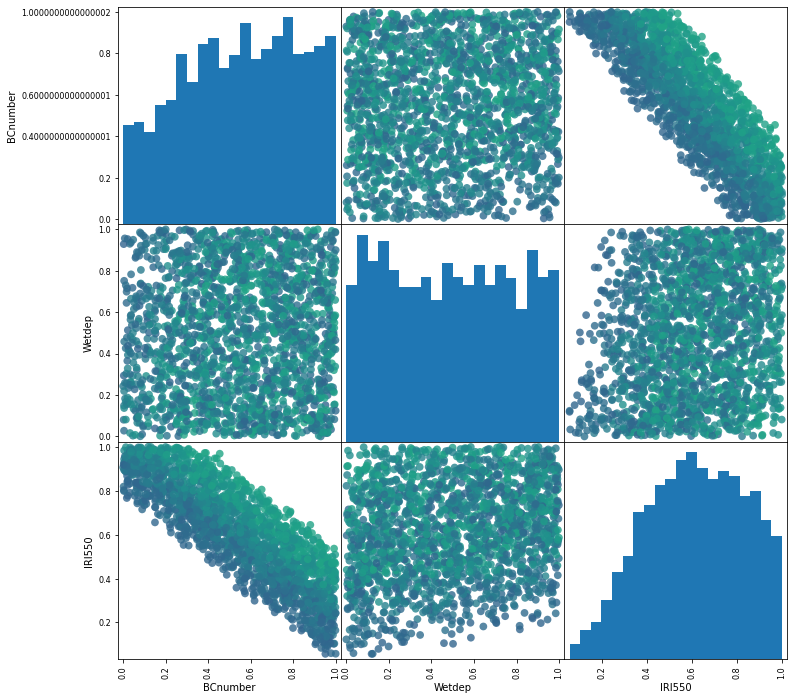

In [24]:
grr = pd.plotting.scatter_matrix(valid_points, c=Zs, figsize=(12, 12), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8, vmin=1e-3, vmax=5e-3)